In [51]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression

from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import prep_plays
import wrangle_plays_data


plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
week1 = pd.read_csv('week1.csv')
#plays = pd.read_csv('plays.csv')
#plays = pd.read_csv('plays.csv')

plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.0,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


In [85]:
plays = plays[plays.playType == 'play_type_pass']
plays['passResult'].replace({'C': 0,'I' : 1, 'IN' : 1}, inplace=True)

In [3]:
df = prep_plays.prep_plays_data()

In [4]:
pd.set_option('display.max_columns',None)
df

,playDescription,quarter,down,yardsToGo,team_by_comp_yds,defendersInTheBox,numberOfPassRushers,QB_under_pressure,gameClock,absoluteYardlineNumber,epa,pass_stopped,playResult,RB,TE,WR,DL,LB,DB,EMPTY,I_FORM,JUMBO,PISTOL,SHOTGUN,SINGLEBACK,WILDCAT,four_three,three_four,nickel,dime
0,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,3,7.0,4.0,0.0,15:00:00,90.0,0.261827,0,10,2,1,2,4,2,5,0,1,0,0,0,0,0,0,0,1,0
1,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,3,7.0,4.0,0.0,13:10:00,49.0,-0.372360,1,0,1,1,3,4,2,5,0,0,0,0,0,1,0,0,0,1,0
2,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,3,6.0,4.0,0.0,13:05:00,49.0,-0.702779,1,0,2,1,2,4,2,5,0,0,0,0,1,0,0,0,0,1,0
3,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,3,6.0,5.0,1.0,13:01:00,49.0,3.047530,0,33,1,1,3,4,1,6,0,0,0,0,1,0,0,0,0,0,1
4,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,3,8.0,6.0,0.0,10:59:00,11.0,-0.842272,1,0,2,3,0,6,3,2,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,(2:19) (Shotgun) P.Rivers pass short right to ...,4,2,2,19,6.0,4.0,0.0,02:19:00,77.0,0.460543,0,7,1,1,3,1,5,5,0,0,0,0,1,0,0,0,0,1,0
17003,(2:00) (Shotgun) P.Rivers pass short left to K...,4,1,10,19,4.0,5.0,0.0,02:00:00,70.0,0.712741,0,17,1,1,3,1,4,6,0,0,0,0,1,0,0,0,0,0,1
17004,(1:41) (Shotgun) P.Rivers pass incomplete shor...,4,1,10,19,5.0,5.0,0.0,01:41:00,53.0,-0.229687,1,0,1,1,3,1,4,6,0,0,0,0,1,0,0,0,0,0,1
17005,(1:37) (Shotgun) P.Rivers pass incomplete deep...,4,2,10,19,4.0,4.0,0.0,01:37:00,53.0,-0.460746,1,0,1,1,3,1,4,6,0,0,0,0,1,0,0,0,0,0,1


# Does a teams offense matter for a successful defensive pass interruption?

$H_o$ : A team's offense is not correlated to a defensive pass interruption.

$H_a$ : A team's offense is correlated with a defensive pass interruption.

$a$ : $.05$

Pearsonr Correlation Test
> Is there a linear relationship with team_by_comp_yds and pass_stopped?

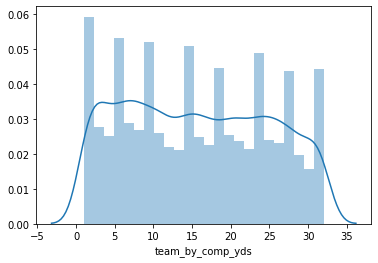

In [5]:
sns.distplot(df.team_by_comp_yds)

In [97]:
team_pass = plays.groupby('possessionTeam').passResult.sum().reset_index()
team_pass = team_pass.sort_values(by='passResult', ascending=False)
team_pass.reset_index(drop=True, inplace=True)
team_pass

,possessionTeam,passResult
0,GB,246
1,PIT,228
2,BUF,227
3,NYJ,223
4,BAL,220
5,CLE,219
6,TB,217
7,IND,212
8,CIN,211
9,ARI,210


In [102]:
team_pass.possessionTeam

0      GB
1     PIT
2     BUF
3     NYJ
4     BAL
5     CLE
6      TB
7     IND
8     CIN
9     ARI
10    JAX
11    DEN
12    NYG
13     LA
14    WAS
15    DET
16     NE
17    ATL
18     KC
19    CAR
20     SF
21    PHI
22    OAK
23    DAL
24    MIN
25    HOU
26    MIA
27    CHI
28    LAC
29    TEN
30     NO
31    SEA
Name: possessionTeam, dtype: object

In [ ]:
#x_order=['GB','PIT','BUF','NYJ','BAL','CLE','TB','IND','CIN','ARI','JAX','DEN','NYG',
#                    'LA','WAS','DET','NE','ATL','KC','CAR','SF','PHI','OAK','DAL','MIN',
#                    'HOU','MIA','CHI','LAC','TEN','NO','SEA'])

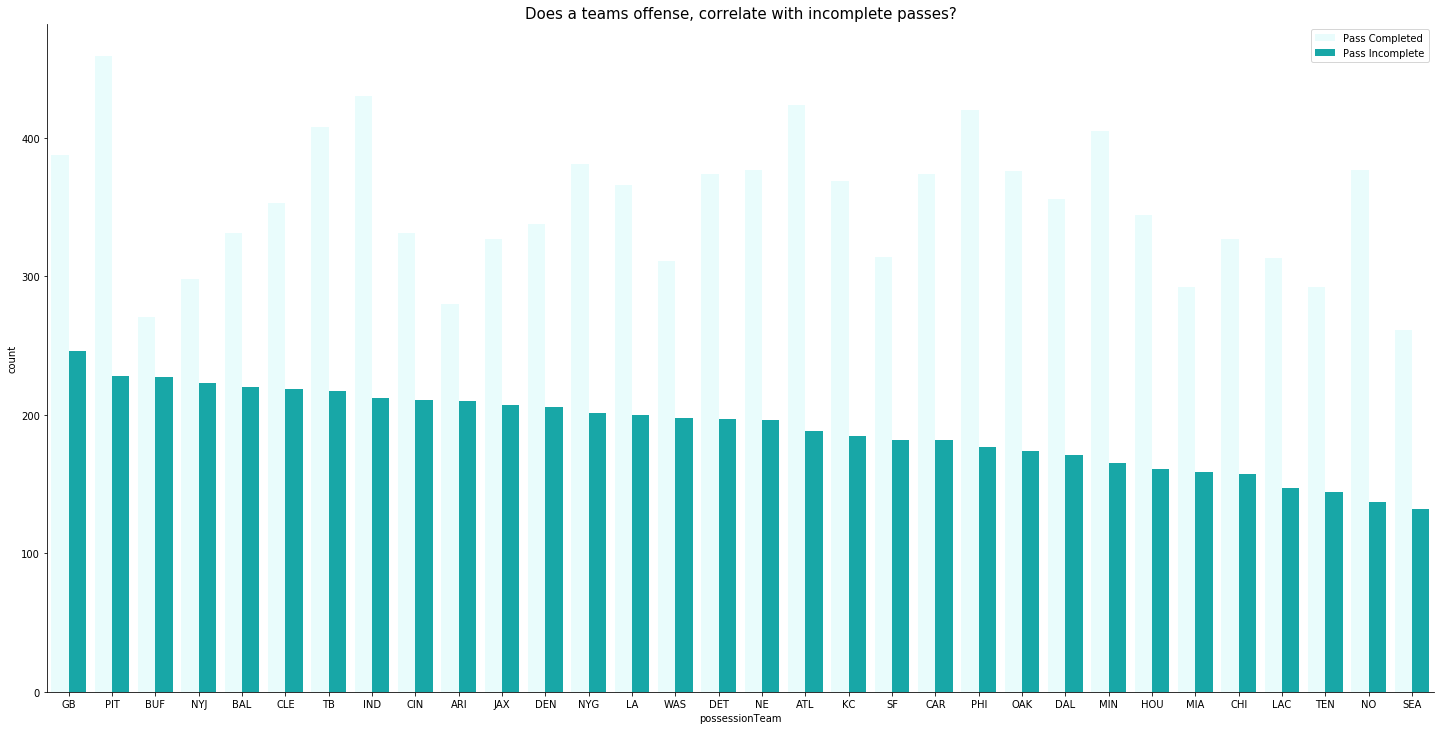

In [117]:
plot_order = plays.groupby('possessionTeam')['passResult'].sum().sort_values(ascending=False).index.values

sns.catplot(x="possessionTeam", hue="passResult", kind="count", data=plays, height=10, aspect=2,
            order = plot_order, color ='c')._legend.remove()
sns.color_palette = ('husl',8)
plt.title('Does a teams offense, correlate with incomplete passes?', size = 15)
plt.legend(labels=('Pass Completed', 'Pass Incomplete'))

In [6]:
corr, p = stats.pearsonr(df.team_by_comp_yds, df.pass_stopped)
corr, p
print('p:', p)
if p < .05:
    print('We reject the null hypothesis that there is no relationship with a teams offense and pass blocked.')
else:
    print('We fail to reject the null hypothesis.')

p: 2.029505834470611e-09
We reject the null hypothesis that there is no relationship with a teams offense and pass blocked.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17001 entries, 0 to 17006
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   playDescription         17001 non-null  object 
 1   quarter                 17001 non-null  int64  
 2   down                    17001 non-null  int64  
 3   yardsToGo               17001 non-null  int64  
 4   team_by_comp_yds        17001 non-null  int64  
 5   defendersInTheBox       17001 non-null  float64
 6   numberOfPassRushers     17001 non-null  float64
 7   QB_under_pressure       17001 non-null  object 
 8   gameClock               17001 non-null  object 
 9   absoluteYardlineNumber  17001 non-null  float64
 10  epa                     17001 non-null  float64
 11  pass_stopped            17001 non-null  int64  
 12  playResult              17001 non-null  int64  
 13  RB                      17001 non-null  object 
 14  TE                      17001 non-null

____________________

# Logistic Regression Modeling
> All features except playDescription, and gameClock.

In [74]:
#X = df[['quarter', 'down', 'yardsToGo', 'team_by_comp_yds', 'defendersInTheBox',
#       'numberOfPassRushers', 'QB_under_pressure', 'absoluteYardlineNumber',
#       'epa', 'playResult', 'RB', 'TE', 'WR', 'DL', 'LB', 'DB', 'EMPTY',
#       'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT',
#       'four_three', 'three_four', 'nickel', 'dime']]

#X = df.drop(columns= ['playDescription','pass_stopped', 'gameClock','playResult','EMPTY', 'I_FORM', 'JUMBO',
#                                     'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT',
#                                     'RB', 'TE', 'WR'])

#X = df[['yardsToGo', 'defendersInTheBox', 'numberOfPassRushers',
#       'QB_under_pressure', 'epa', 'playResult', 'RB', 'TE', 'WR', 'DL', 'LB',
#       'DB', 'EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK']]

##### BEST features for Logistic regression
#X = df.drop(columns= ['playDescription','pass_stopped', 'gameClock'])

###### BEST features for KNN
X = df[['yardsToGo', 'numberOfPassRushers', 'epa', 'playResult', 'RB',
        'EMPTY', 'I_FORM', 'PISTOL', 'SHOTGUN', 'SINGLEBACK']]

#X = df[['yardsToGo', 'numberOfPassRushers', 'epa', 'playResult', 'RB']]

y = df[['pass_stopped']]

In [75]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size = .40, random_state = 123)

print("train: ", X_train.shape, ", validate: ", X_validate.shape, ", test: ", X_test.shape)
print("train: ", y_train.shape, ", validate: ", y_validate.shape, ", test: ", y_test.shape)

train:  (7140, 10) , validate:  (4760, 10) , test:  (5101, 10)
train:  (7140, 1) , validate:  (4760, 1) , test:  (5101, 1)


In [76]:
scaler = MinMaxScaler(copy = True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns.values).set_index([X_train.index.values])
X_validate_scaled = pd.DataFrame(X_validate_scaled, columns = X_validate.columns.values).set_index([X_validate.index.values])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns.values).set_index([X_test.index.values])

In [84]:
# creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_train)

y_pred_proba = logit.predict_proba(X_train)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on TRAIN-unscaled set: {:.2f}'
     .format(logit.score(X_train, y_train)))

print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))
print('')
############
print('***** VALIDATE *****')

#logit.fit(X_validate, y_validate)

#LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
#                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
#                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
#                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_validate)

y_pred_proba = logit.predict_proba(X_validate)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on VALIDATE-unscaled set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))

print(confusion_matrix(y_validate, y_pred))

print(classification_report(y_validate, y_pred))
print('')
##########
print('***** TEST *****')

# fit the model
#logit.fit(X_test, y_test)

#LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
#                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
#                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
#                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_test)

y_pred_proba = logit.predict_proba(X_test)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on TEST-unscaled set: {:.2f}'
     .format(logit.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Coefficient: 
 [[ 0.08176925  0.35342682 -0.15025567 -0.63654441 -0.45898251 -2.06905709
  -2.01779325 -2.22162445 -1.64636573 -2.0018366 ]]
Intercept: 
 [5.15488028]
>>>>>>>>>> Accuracy of Logistic Regression classifier on TRAIN-unscaled set: 0.72
[[2589 2017]
 [   6 2528]]
              precision    recall  f1-score   support

           0       1.00      0.56      0.72      4606
           1       0.56      1.00      0.71      2534

    accuracy                           0.72      7140
   macro avg       0.78      0.78      0.72      7140
weighted avg       0.84      0.72      0.72      7140


***** VALIDATE *****
Coefficient: 
 [[ 0.08176925  0.35342682 -0.15025567 -0.63654441 -0.45898251 -2.06905709
  -2.01779325 -2.22162445 -1.64636573 -2.0018366 ]]
Intercept: 
 [5.15488028]
>>>>>>>>>> Accuracy of Logistic Regression classifier on VALIDATE-unscaled set: 0.71
[[1784 1379]
 [   5 1592]]
              precision    recall  f1-score   support

           0       1.00      0.56      0.

In [82]:
# SCALED creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_train_scaled, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_train_scaled)

y_pred_proba = logit.predict_proba(X_train_scaled)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on TRAIN set: {:.2f}'
     .format(logit.score(X_train_scaled, y_train)))
print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))
print('')
##########
print('***** VALIDATE *****')
#logit.fit(X_validate_scaled, y_validate)

#LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
#                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
#                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
#                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_validate_scaled)

y_pred_proba = logit.predict_proba(X_validate_scaled)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on VALIDATE set: {:.2f}'
     .format(logit.score(X_validate_scaled, y_validate)))

print(confusion_matrix(y_validate, y_pred))

print(classification_report(y_validate, y_pred))
print('')
##########
print('***** TEST *****')
#logit.fit(X_test_scaled, y_test)

#LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
#                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
#                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
#                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_test_scaled)

y_pred_proba = logit.predict_proba(X_test_scaled)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on TEST set: {:.2f}'
     .format(logit.score(X_test_scaled, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))


Coefficient: 
 [[  0.96280103   2.04628374 -17.74475926 -47.82312755  -1.30038993
   -2.37588116  -2.11812894  -2.73309468  -2.06188907  -2.19896599]]
Intercept: 
 [34.37022501]
>>>>>>>>>> Accuracy of Logistic Regression classifier on TRAIN set: 0.62
[[1894 2712]
 [   6 2528]]
              precision    recall  f1-score   support

           0       1.00      0.41      0.58      4606
           1       0.48      1.00      0.65      2534

    accuracy                           0.62      7140
   macro avg       0.74      0.70      0.62      7140
weighted avg       0.81      0.62      0.61      7140


***** VALIDATE *****
Coefficient: 
 [[  0.96280103   2.04628374 -17.74475926 -47.82312755  -1.30038993
   -2.37588116  -2.11812894  -2.73309468  -2.06188907  -2.19896599]]
Intercept: 
 [34.37022501]
>>>>>>>>>> Accuracy of Logistic Regression classifier on VALIDATE set: 0.60
[[1275 1888]
 [   4 1593]]
              precision    recall  f1-score   support

           0       1.00      0.40    

# KNN modeling

In [79]:
# TRAIN creating object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

y_pred = knn.predict(X_train_scaled)

y_pred_proba = knn.predict_proba(X_train_scaled)

print('>>>>>>>>>> Accuracy of KNN classifier on TRAIN set: {:.2f}'
     .format(knn.score(X_train_scaled, y_train)))

print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))

print('')

print('***** VALIDATE *****')

#knn.fit(X_validate_scaled, y_validate)

#KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     #metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     #weights='uniform')

y_pred = knn.predict(X_validate_scaled)

y_pred_proba = knn.predict_proba(X_validate_scaled)

print('>>>>>>>>>> Accuracy of KNN classifier on VALIDATE set: {:.2f}'
      .format(knn.score(X_validate_scaled, y_validate)))

print(confusion_matrix(y_validate, y_pred))

print(classification_report(y_validate, y_pred))

print('')

print('***** TEST *****')

#knn.fit(X_test_scaled, y_test)

#KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     #metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     #weights='uniform')

y_pred = knn.predict(X_test_scaled)

y_pred_proba = knn.predict_proba(X_test_scaled)

print('>>>>>>>>>> Accuracy of KNN classifier on TEST set: {:.2f}'
      .format(knn.score(X_test_scaled, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

>>>>>>>>>> Accuracy of KNN classifier on TRAIN set: 0.94
[[4275  331]
 [  94 2440]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      4606
           1       0.88      0.96      0.92      2534

    accuracy                           0.94      7140
   macro avg       0.93      0.95      0.94      7140
weighted avg       0.94      0.94      0.94      7140


***** VALIDATE *****
>>>>>>>>>> Accuracy of KNN classifier on VALIDATE set: 0.91
[[2882  281]
 [ 126 1471]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3163
           1       0.84      0.92      0.88      1597

    accuracy                           0.91      4760
   macro avg       0.90      0.92      0.91      4760
weighted avg       0.92      0.91      0.92      4760


***** TEST *****
>>>>>>>>>> Accuracy of KNN classifier on TEST set: 0.92
[[2999  286]
 [ 124 1692]]
              precision    recall  f1-score   suppor

([<matplotlib.axis.XTick at 0x7fc4154145d0>,
 <a list of 5 Text xticklabel objects>)

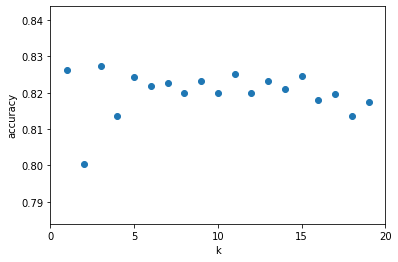

In [22]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

### RFE Feature Engineering

In [80]:
### RFE

number_of_features_list=np.arange(1,29)
high_score=0

#Variable to store the optimum features
number_of_features=10           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LogisticRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 1
Score with 1 features: 0.954323


In [81]:
cols = list(X_train_scaled.columns)
model = LogisticRegression()

#Initializing RFE model
rfe = RFE(model, 10)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['yardsToGo', 'numberOfPassRushers', 'epa', 'playResult', 'RB', 'EMPTY',
       'I_FORM', 'PISTOL', 'SHOTGUN', 'SINGLEBACK'],
      dtype='object')


### Select K Best

In [53]:
f_selector = SelectKBest(f_regression, k=5)

f_selector.fit(X_train_scaled, y_train)

f_support = f_selector.get_support()
f_feature = X_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

5 selected features
['yardsToGo', 'numberOfPassRushers', 'epa', 'playResult', 'RB']


# wangle-functions

In [27]:
#plays["offenseFormation"].replace({"I_FORM": "IFORM"}, inplace=True)

#plays = plays[plays['offenseFormation'].notna()]

#plays = plays[plays['typeDropback'].notna()]

#plays.personnelD.isna().sum()



#ohe = OneHotEncoder(sparse=False)

#ohe.fit_transform(plays[['personnelO']]).shape

#plays['possessionTeam'].replace({'TRADITIONAL':0,'SCRAMBLE_ROLLOUT_RIGHT':1,
#                                 'SCRAMBLE':2,'DESIGNED_ROLLOUT_RIGHT':3,
#                                 'SCRAMBLE_ROLLOUT_LEFT':4,'DESIGNED_ROLLOUT_LEFT':5,
#                                 'UNKNOWN':6}, inplace=True)

#plays['offenseFormation'].replace({'SHOTGUN':0,'SINGLEBACK':1,'EMPTY':2,'I_FORM':3,
#                                   'PISTOL':4,'JUMBO':5,'WILDCAT':6}, inplace=True)

#plays['possessionTeam'].replace({'PIT':0,'GB':1,'TB':2,'IND':3,'ATL':4,'PHI':5,'NYG':6,'DET':7,
#                                'CLE':8,'MIN':9,'LA':10,'OAK':11,'NE':12,'BAL':13,'CAR':14,
#                                'DAL':15,'CIN':16,'DEN':17,'JAX':18,'KC':19,'HOU':20,'WAS':21,
#                                'SF':22,'NYJ':23,'ARI':24,'NO':25,'BUF':26,'CHI':27,'MIA':28,
#                                'LAC':29,'TEN':30,'SEA':31}, inplace=True)

### sklearn pipeline column transformer w/ one hot encoding

In [28]:
#print('Decision Tree with 7 features')
#print('Accuracy:',cross_val_score(estimator = clf, pipe_dt, X_train, y_train, cv=5, n_jobs=4,scoring='accuracy').mean())
#print('Precision:',cross_val_score(pipe_nb, X_train, y_train, cv=5, scoring='precision').mean())
#print('Recall:',cross_val_score(pipe_nb, X_train, y_train, cv=5, scoring='recall').mean())

In [29]:
#models = [GaussianNB(), DecisionTreeClassifier(), SVC(), LogisticRegression(solver='lbfgs')]
#names = ["Naive Bayes", "Decision Tree", "SVM","Logistic Regression"]
#for model, name in zip(models, names):
#    print(name)
#    for score in ["accuracy", "precision", "recall"]:
#        print(score)
#        print (cross_val_score(pipe, X_train, y_train, cv=5, scoring=score).mean())

In [30]:
#y_pred = logit.predict(pipe, X_train)